In [172]:
import analyses.spectr_stitch_images as ssi
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cv2 as cv
import statistics
import skimage as ski
from skimage.morphology import square,disk
from scipy import signal
from scipy import stats
from pathlib import Path
import hashlib
import numbers
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Try stitching

In [2]:
Date = '2024/09/14'
DATA_PATH = f'/eos/experiment/awake/event_data/{Date}'
event_files = os.listdir(DATA_PATH)

In [3]:
def load_images(event):
    list_images = []
    
    for i in np.arange(1,8,1):
        selectedEvent = os.path.join(DATA_PATH, event_files[event])
        with h5py.File(selectedEvent, 'r') as selectedEventFile:
            eventImg = selectedEventFile['AwakeEventData'][f'TCC4.SPECTRO{i}.DigiCam']['ExtractionImage']['image2D'][:]

            list_images.append(eventImg)
            
    return list_images

In [28]:
list_images = load_images(1170)

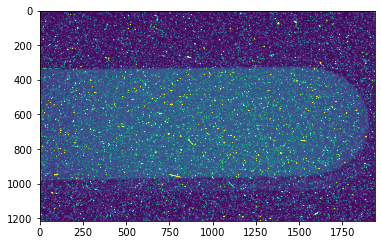

In [18]:
plt.imshow(list_images[6],vmax=300)

*** cam 1
*** cam 2
*** cam 3
*** cam 4
*** cam 5
*** cam 6
*** cam 7
1.0853827
1.050351
1.0690484
1.3105896
1.3115433
1.3203403
using stitched image
[-6.22058492e+00  9.22506043e+02 -4.68234569e+03  2.07947221e+04
 -6.60287957e+04  1.53653307e+05 -2.59696960e+05  3.04942544e+05
 -2.24145360e+05  7.81057455e+04]
[-1.36534425e+01  9.34042164e+02 -4.73926539e+03  2.11503906e+04
 -6.78043988e+04  1.59704892e+05 -2.73495191e+05  3.25433499e+05
 -2.42307443e+05  8.54746089e+04]
[-1.59407802e+01  9.31050140e+02 -4.74471930e+03  2.14052238e+04
 -6.95986269e+04  1.66527814e+05 -2.89789500e+05  3.50247841e+05
 -2.64679171e+05  9.46750771e+04]
[-1.67318093e+01  9.26660769e+02 -4.73035066e+03  2.14950256e+04
 -7.05808746e+04  1.70752992e+05 -3.00508030e+05  3.67191534e+05
 -2.80363302e+05  1.01257848e+05]
[-1.65099732e+01  9.19542896e+02 -4.69552599e+03  2.14419440e+04
 -7.08621689e+04  1.72641738e+05 -3.05947480e+05  3.76286166e+05
 -2.89039112e+05  1.04966864e+05]
[-1.63931491e+01  9.17339894e+

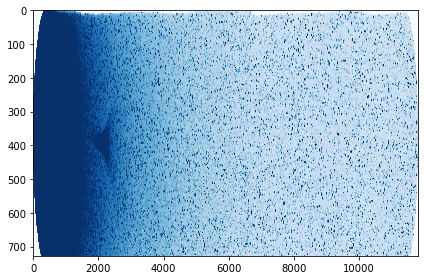

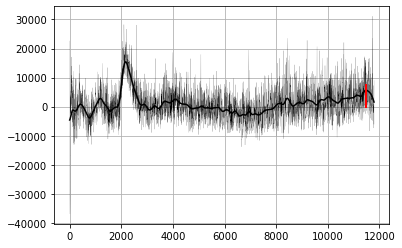

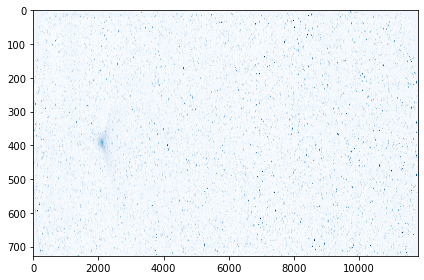

In [46]:
stitched_image = ssi.main2(list_images, apply_lens_distortion=True, bin_factor=2, plot=True)

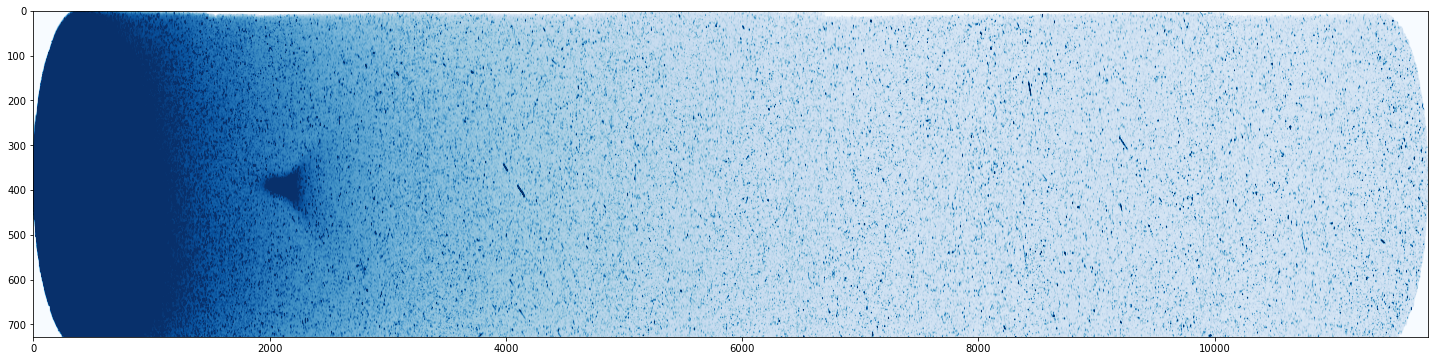

In [131]:
plt.figure(figsize=(25,6))

plt.imshow(stitched_image, cmap='Blues',vmax=600,aspect='auto')
plt.show()

# Add background subtraction

In [4]:
def check_plunger_states(files, plengths=None):
    """
    Checks is plunger in the line, and which one.....
    """
    if plengths is None:

        plengths = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.3]
        
    results = []

    for i, file_path in enumerate(files):
        
        plunger_state = 0
        plunger_in = None
        is_there_a_plunger = 0
 
        try:

            with h5py.File(file_path, 'r') as f:
                
                for p in range(len(plengths)):
                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PE_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])

                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PG_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])
                        

                    if plunger_state == 3 or plunger_state == 4:
                        plunger_in = p + 1
                        is_there_a_plunger = 1

                        break
 

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

            continue
 
        results.append({
            "index": i,
            "file": file_path,
            "is_there_a_plunger": bool(is_there_a_plunger),
            "plunger_in": plunger_in
        })

    return results

In [5]:
def load_all_event_data(date,event_filename,spectro_no,threshold):
    
    with h5py.File('/eos/experiment/awake/event_data/'+date+'/'+ event_filename, 'r') as f:
        root = f['AwakeEventData']

        # Main data
        spectro_path = f'TCC4.SPECTRO{spectro_no}.DigiCam'

        try:
            data = root[spectro_path]['ExtractionImage']['image2D'][:]
            protons = root['TT41.BCTF.412340']['CaptureAcquisition']['totalIntensity'][0]
            
            ## sort BTV54
            screen_of_interest = root['TT41.BTV.412354.DigiCam']['ExtractionImage']['image2D'][400:610,510:720]
            bg_sensor = np.array(screen_of_interest) - 3.78126279
            w_median_filter = ski.filters.median(bg_sensor, footprint=disk(3)) 

            total_count = np.sum(w_median_filter)

            if protons !=0 and total_count > threshold:
                BTV54_position = 1

            else:
                BTV54_position = 0
                
                
            rif = root['Sps2AwakeSynchro']['ProtonDelayNs']['delay'][0]
            plunger_status = check_plunger_states(['/eos/experiment/awake/event_data/'+date+'/'+ event_filename])
            laser_firing = root['EMETER04']['Acq']['value'][0]

            ## sort based on threshold
            if laser_firing > 0.05:
                laser_value = 1

            else:
                laser_value = 0

            # Screens
            screens = {
                'OTR': root['MPP-VACTRANS-OTR']['Acquisition']['end_switch_plus_active'][()],
                'CTR': root['MPP-VACTRANS-CTR']['Acquisition']['end_switch_plus_active'][()],
                'LDBP': root['LBDP2']['Acq']['position'][0],
                'Plunger': plunger_status[0]['plunger_in'],
            }

                
        except(ValueError, KeyError):
            protons=0
            BTV54_position = 0
            data = np.zeros((1216,1936))
            screens = {'OTR': 0,
                'CTR': 0,
                'LDBP': 0,
                'Plunger': 0,}
            rif = 0 
            laser_value = 0 
    
    return data, protons, rif, laser_value, screens

In [6]:
def check_screens(screens):

    active_screens = []
    list_screens = ['OTR','CTR','BTV50','BTV53', 'BTV426', 'BTV442', 'LDBP','Plunger', 'BTV54']

    # Determine which screen is active
    screen_used = None
    for screen in list_screens: 
        val = screens.get(screen,None)

        if screen =='LDBP':
            val = screens['LDBP']
            if val == 0:
                active_screens.append('LDBP')

        elif screen == 'Plunger':
            val = screens['Plunger']

            for j in np.arange(1,11,1):
                if val == j:
                    active_screens.append(f'Plunger{j}')                

        elif isinstance(val, (bool, np.bool_)):
            if val == False:
                active_screens.append(screen)

        elif isinstance(val, numbers.Number):
            if float(val) == 1:
                active_screens.append(screen)


    if not active_screens:
        active_screens = ['None']

    # Create a combined label
    screen_label = '+'.join(active_screens)
    return screen_label

In [7]:
def background_subtraction(Date, event, camera_number, threshold, stored_event):
    
    ## load data
    event_files = os.listdir(f'/eos/experiment/awake/event_data/{Date}')
    data, protons, rif, laser, screens = load_all_event_data(Date,event_files[event],spectro_no=camera_number,threshold=1.3e6)
    
    ## remove electronic noise and median filter
    bg_sensor = np.array(data) - 3.78126279
    data_w_median_filter = ski.filters.median(bg_sensor, footprint=disk(4)) 
    
    screen_label = check_screens(screens)
    
    date_format = Date.replace('/','-')
        
    m_c_data = np.load(f"slope_intercept_data_{date_format}_Spectro_{camera_number}_Upto_Event_{stored_event}_screens_{screen_label}_nofilter.npz")
    slopes = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope"]
    intercepts = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercepts"]
    sigma_mm = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_errors"]
    sigma_cc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercept_errors"]
    sigma_mc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_int_errors"]
    
     
    background = slopes*protons + intercepts
    
    variance = (protons**2) * sigma_mm + 2 * protons * sigma_mc + sigma_cc
    pixel_uncertainty = np.sqrt(np.abs(variance))  
    pixel_uncertainty = np.nan_to_num(pixel_uncertainty, nan=0.0, posinf=0.0, neginf=0.0)
    
    print("Shapes - slopes:", slopes.shape, "intercepts:", intercepts.shape, "data:", data.shape)
    print("Protons:", protons)

    cleaned_image = data_w_median_filter - background
    
    return cleaned_image, pixel_uncertainty

In [8]:
def fit_to_spectrometer_no_filter(rif_data, no_events, Date, camera_number):
    saved_slopes_intercepts = {}
    list_rifs = list(rif_data)
    
    for rif in list_rifs:
        list_laser_values = list(rif_data[rif])
        
        for laser in list_laser_values:
            list_screen_combos = list(rif_data[rif][laser])

            for screen_label in list_screen_combos:
                data = rif_data[rif][laser][screen_label]
                index_count = list(data)

                slope_heat_map = np.zeros((1216, 1936))
                intercept_error_hm = np.zeros((1216, 1936))
                slope_int_error_hm = np.zeros((1216, 1936))
                
                slope_error_hm = np.zeros((1216, 1936))
                intercept_heat_map = np.zeros((1216, 1936))

                for i in index_count:
                    x = np.array(data[i]['proton_count'])  
                    y = np.array(data[i]['fit_parameters'])

                    if len(x) >= 3 and i != 'full_image':  # Curve fitting requires at least two data points
                        params,pcov = curve_fit(fit_line, x, y)
                        a, b = params
                        c, d = np.diag(pcov)
                        e = (pcov[0,1])

                        slope_heat_map[i[0]:i[1],i[2]:i[3]] = a 
                        intercept_heat_map[i[0]:i[1],i[2]:i[3]] = b
                        
                        slope_error_hm[i[0]:i[1],i[2]:i[3]] = c
                        intercept_error_hm[i[0]:i[1],i[2]:i[3]] = d
                        slope_int_error_hm[i[0]:i[1],i[2]:i[3]] = e


                ## write to dictionary
                key = f"RIF_{rif}_Laser_{laser}_Screens_{screen_label}"
                saved_slopes_intercepts[f"{key}_slope"] = slope_heat_map
                saved_slopes_intercepts[f"{key}_intercepts"] = intercept_heat_map
                saved_slopes_intercepts[f"{key}_slope_errors"] = slope_error_hm
                saved_slopes_intercepts[f"{key}_intercept_errors"] = intercept_error_hm
                saved_slopes_intercepts[f"{key}_slope_int_errors"] = slope_int_error_hm
                
    date_format = Date.replace('/','-')
    np.savez_compressed(f"slope_intercept_data_{date_format}_Spectro_{camera_number}_Upto_Event_{no_events}_screens_{screen_label}_nofilter.npz",**saved_slopes_intercepts)
    
    return 'Your dataset has been saved'

In [86]:
def sort_by_space_scin_screen(start_y, end_y,start_events,end_events,Date,camera_number,electronic_noise,rot):
    
    y_step = 1
    x_step = 1
    
    list_indices_y = list(range(start_y, end_y, y_step))
    list_indices_x = list(range(0, 1936, 1))
    
    rif_data = {}
    
    DATA_PATH = f'/eos/experiment/awake/event_data/{Date}'
    event_files = os.listdir(DATA_PATH)

    for i in np.arange(start_events,end_events,1):
        filename = event_files[i]
        
        data, protons, rif, laser, screens = load_all_event_data(Date,filename,spectro_no=camera_number,threshold=1750000)
        
        ## rotate data by angle
        data_rot = nd.rotate(data, angle=rot, reshape=False)
        bg_sensor = np.array(data_rot) - electronic_noise
        w_median_filter = ski.filters.median(bg_sensor, footprint=disk(4)) 
        
        if rif not in rif_data:
            rif_data[rif] = {}
            
        if laser not in rif_data[rif]:
             rif_data[rif][laser] = {}
            
        ## check what screens are in
        active_screens = []
        list_screens = ['OTR','CTR','BTV50','BTV53', 'BTV426', 'BTV442', 'LDBP','Plunger', 'BTV54']

        # Determine which screen is active
        screen_used = None
        for screen in list_screens: 
            val = screens.get(screen,None)

            if screen =='LDBP':
                val = screens['LDBP']
                if val == 0:
                    active_screens.append('LDBP')

            elif screen == 'Plunger':
                val = screens['Plunger']

                for j in np.arange(1,11,1):
                    if val == j:
                        active_screens.append(f'Plunger{j}')                

            elif isinstance(val, (bool, np.bool_)):
                if val == False:
                    active_screens.append(screen)
 
            elif isinstance(val, numbers.Number):
                if float(val) == 1:
                    active_screens.append(screen)

                    
        if not active_screens:
            active_screens = ['None']

        # Create a combined label
        screen_label = '+'.join(active_screens)

        if screen_label not in rif_data[rif][laser]:
            rif_data[rif][laser][screen_label] = {'full_image': {'fit_parameters': [], 'proton_count': [] }}
            
            
            
        ## Add full camera image
        rif_data[rif][laser][screen_label]['full_image']['fit_parameters'].append(np.mean(w_median_filter[start_y:end_y,0:]))
        rif_data[rif][laser][screen_label]['full_image']['proton_count'].append(protons)

        for i in list_indices_y:
            for j in list_indices_x:        
                sliced_data = w_median_filter[i:i+y_step,j:j+x_step]
                #print(np.mean(sliced_data))

                index_cut = (i, i+y_step , j, j+x_step)

                if index_cut not in rif_data[rif][laser][screen_label]:
                    rif_data[rif][laser][screen_label][index_cut] = {
                        'fit_parameters': [], 'proton_count': []}

                rif_data[rif][laser][screen_label][index_cut]['fit_parameters'].append(np.mean(sliced_data))
                rif_data[rif][laser][screen_label][index_cut]['proton_count'].append(protons)


    return rif_data

In [10]:
def fit_line(x,a,b):
    return a*x + b

# Measure the background

In [ ]:
## spec 1

In [47]:
spec1 = sort_by_space_scin_screen(680,1936,1159,1163,'2024/09/14',1,3.78)

In [50]:
fit_to_spectrometer_no_filter(spec1, 5,'2024/09/14',1)

/tmp/ipykernel_856/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [11]:
background_spec1 , uncertainty_spec1 = background_subtraction('2024/09/14',1170, 1, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [53]:
## spec 2

In [56]:
spec2 = sort_by_space_scin_screen(680,1936,1159,1163,'2024/09/14',2,3.78)

In [58]:
fit_to_spectrometer_no_filter(spec2, 5,'2024/09/14',2)

/tmp/ipykernel_856/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [12]:
background_spec2 , uncertainty_spec1 = background_subtraction('2024/09/14',1170, 2, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [62]:
## spec 3
## want to use limits of 300, 960

In [87]:
spec3 = sort_by_space_scin_screen(300,960,1159,1163,'2024/09/14',3,-0.28,rot=0)

In [89]:
#spec3

In [105]:
fit_to_spectrometer_no_filter(spec3, 5,'2024/09/14',3)

/tmp/ipykernel_464/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [106]:
background_spec3 , uncertainty_spec3 = background_subtraction('2024/09/14',1170, 3, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [63]:
## spec 4
## want to use limits of 250, 900

In [91]:
spec4 = sort_by_space_scin_screen(250,900,1159,1163,'2024/09/14',4,0.13,rot=0)

In [95]:
fit_to_spectrometer_no_filter(spec4, 5,'2024/09/14',4)

/tmp/ipykernel_464/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [96]:
background_spec4 , uncertainty_spec4 = background_subtraction('2024/09/14',1170, 4, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [67]:
## spec 5
## 300 to 920 (with -0.9 rotation??)

In [146]:
spec5 = sort_by_space_scin_screen(305,920,1159,1163,'2024/09/14',5,-6.18,rot=-0.8)

In [147]:
fit_to_spectrometer_no_filter(spec5, 5,'2024/09/14',5)

/tmp/ipykernel_464/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [148]:
background_spec5 , uncertainty_spec5 = background_subtraction('2024/09/14',1170, 5, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [ ]:
## spec 6
## 310 to 940 (also with rotation??)

In [93]:
spec6 = sort_by_space_scin_screen(310,940,1159,1163,'2024/09/14',6,3.08,rot=-0.9)

In [122]:
fit_to_spectrometer_no_filter(spec6, 5,'2024/09/14',6)

/tmp/ipykernel_464/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [123]:
background_spec6 , uncertainty_spec6 = background_subtraction('2024/09/14',1170, 6, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [ ]:
## spec 7 
## 330 to 960 w rotation

In [94]:
spec7 = sort_by_space_scin_screen(330,960,1159,1163,'2024/09/14',7,-1.73,rot=-0.9)

In [ ]:
#     y_step = int(680/space_x)
#     x_step = int(1936/space_y)    
    
#     680,1936
    
#     list_indices_y = list(range(330, 1010, y_step))
#     list_indices_x = list(range(0, 1936, x_step))

In [110]:
fit_to_spectrometer_no_filter(spec7, 5,'2024/09/14',7)

/tmp/ipykernel_464/3950915343.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params,pcov = curve_fit(fit_line, x, y)


'Your dataset has been saved'

In [111]:
background_spec7 , uncertainty_spec7 = background_subtraction('2024/09/14',1170,7, threshold=1.75e6,stored_event=5)

Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [ ]:
## STITCH

In [149]:
list_bg_subs = [background_spec1,background_spec2,background_spec3,background_spec4,background_spec5,background_spec6,background_spec7]

*** cam 1
*** cam 2
*** cam 3
*** cam 4
*** cam 5
*** cam 6
*** cam 7
0.55179584
1.7279882
4.167985
2.5627759
4.7116313
6.12662
using stitched image
[ 5.29716285e+00 -1.06786454e+02  3.02043853e+02  4.45275455e+02
 -5.72630338e+03  2.09993833e+04 -4.54997051e+04  6.25575773e+04
 -5.12342912e+04  1.92970929e+04]
[ 1.59757007e+01 -2.08154030e+02  9.41453004e+02 -2.36503663e+03
  3.05449464e+03  1.14443780e+03 -1.32332030e+04  2.63878265e+04
 -2.59620152e+04  1.09436045e+04]
[    23.6947094    -275.00414056   1338.4734189   -4064.23164803
   8408.55965557 -11336.80259373   7937.52292531   1458.08918417
  -7609.09659443   4545.41675082]
[    30.70385485   -329.81710639   1645.20031339  -5335.44839567
  12363.26396099 -20546.19009814  23645.64327429 -17208.9043982
   6284.76338619   -355.72650395]
[    37.489822     -378.75731926   1904.79134688  -6371.6310022
  15500.29821471 -27705.08986701  35669.22607883 -31326.56962536
  16693.09588803  -3999.48001003]
[ 4.77181015e+01 -4.48520681e+02 

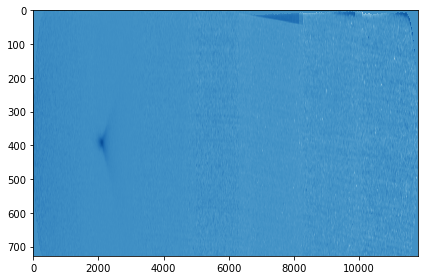

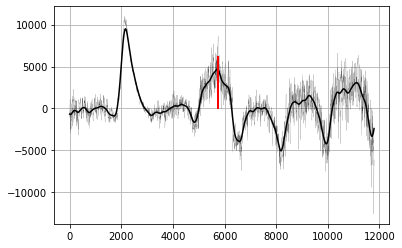

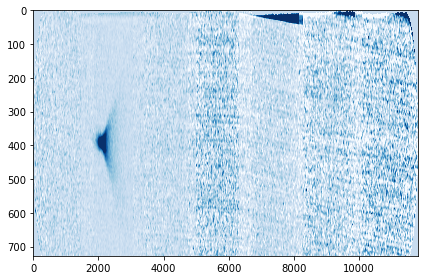

In [150]:
stitched_bg_sub_image = ssi.main2(list_bg_subs, apply_lens_distortion=True, bin_factor=2, plot=True)

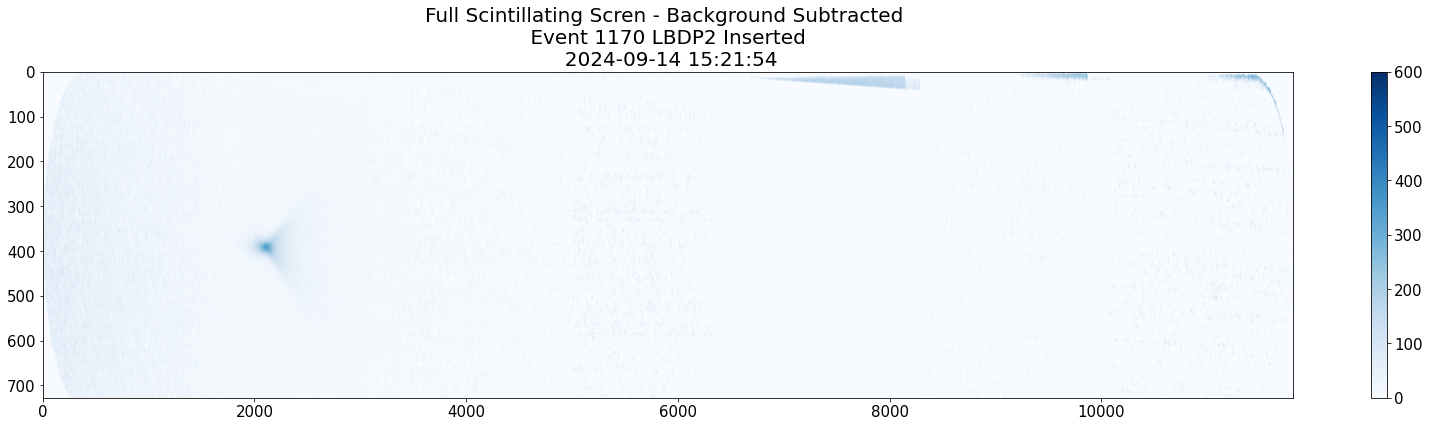

In [177]:
plt.figure(figsize=(28,6))

plt.imshow(stitched_bg_sub_image, cmap='Blues',vmax=600,vmin=0, aspect='auto')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)

plt.title(f'Full Scintillating Scren - Background Subtracted \n Event 1170 LBDP2 Inserted \n  {formatted_timestamp} ',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [156]:
import pandas as pd

In [157]:
selectedEvent =os.path.join(DATA_PATH, event_files[1170])

stamp = int(selectedEvent[44:63])
timestamp = pd.to_datetime(stamp)
formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')

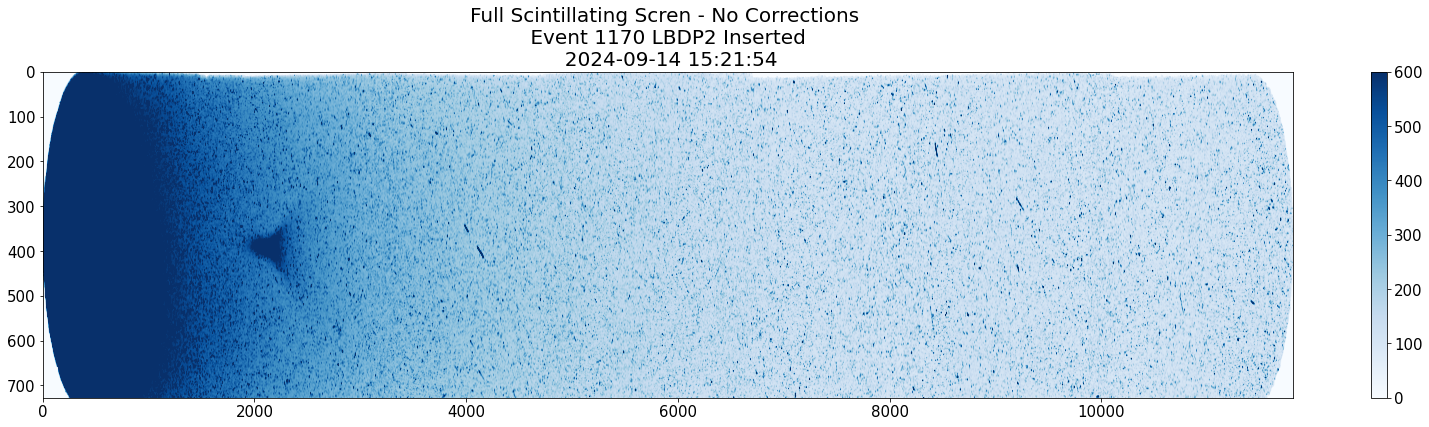

In [178]:
plt.figure(figsize=(28,6))

plt.imshow(stitched_image, cmap='Blues',vmax=600,vmin =0, aspect='auto')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title(f'Full Scintillating Scren - No Corrections \n Event 1170 LBDP2 Inserted \n  {formatted_timestamp} ',fontsize=20)
plt.show()

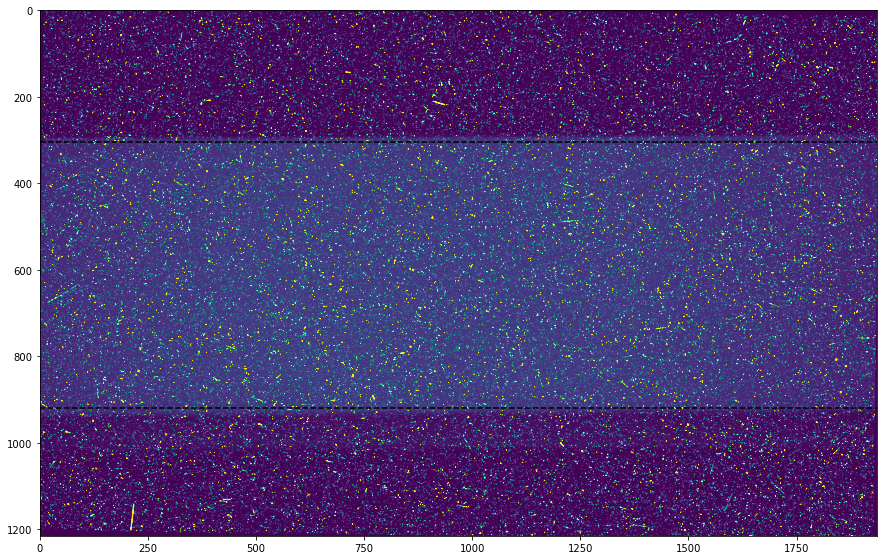

In [145]:
plt.figure(figsize=(15,10))

eventImg = nd.rotate(list_images[4], angle=-0.8, reshape=False)

plt.imshow(eventImg,vmax=500,vmin=0)
plt.axhline(305, linestyle='--', color='k')
plt.axhline(920, linestyle='--', color='k')

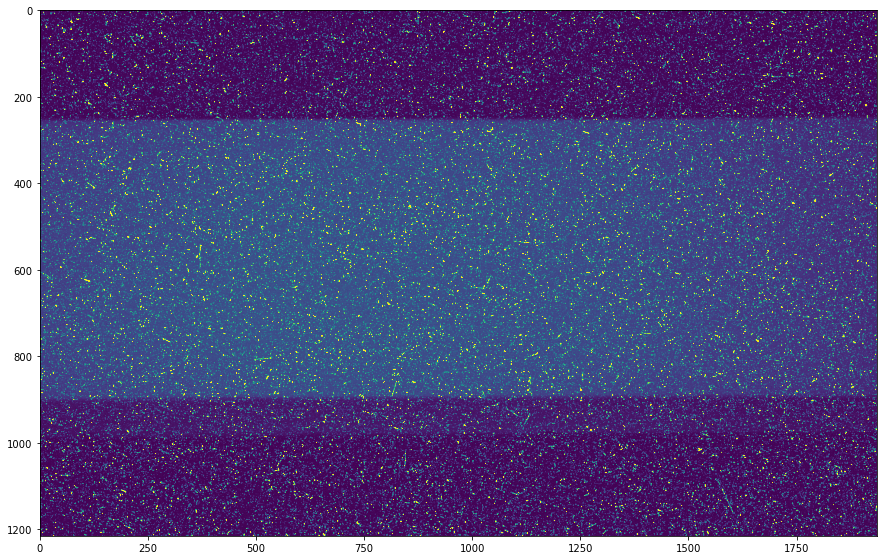

In [40]:
import scipy.ndimage as nd
from scipy.ndimage import rotate
from scipy.interpolate import interp1d

In [43]:
def getNewSpecImage_rotated(event_array, log=False, vmax=None, vmin=None, mf=False, mf_size=4, rot=0):

    for i in event_array:
        try:
            eventImg = i

            if rot != 0:
                eventImg = nd.rotate(eventImg, angle=rot, reshape=False)

            if mf:
                eventImg = nd.median_filter(eventImg, size=mf_size)

            if log:
                eventImg = np.log1p(eventImg)  

            plt.figure(figsize=(8,6))
            #stamp = int(selectedEvent[44:63])
            #timestamp = pd.to_datetime(stamp)
            #formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
            plt.title(f'Rotation \n Event:{i} ')#\n {formatted_timestamp}')
            plt.imshow(eventImg, cmap='inferno', vmax=vmax, vmin=vmin)
            plt.colorbar() 

            #just putting in some horizontal lines to show alignment
            plt.axhline(360, linestyle='--', color='k')
            plt.axhline(990, linestyle='--', color='k')

            plt.show()

        except Exception as e:
            print(f"Failed to process event {i}: {e}")
            continue
            
    return eventImg

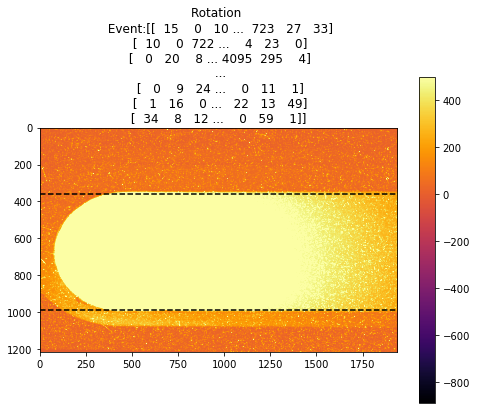

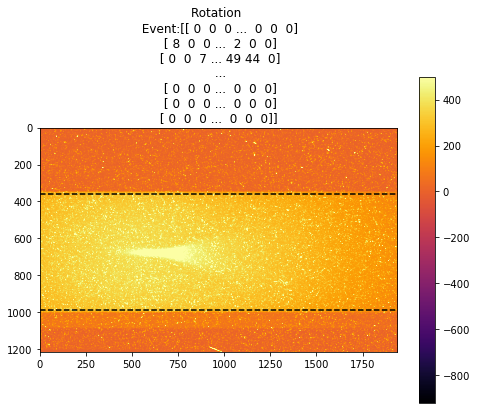

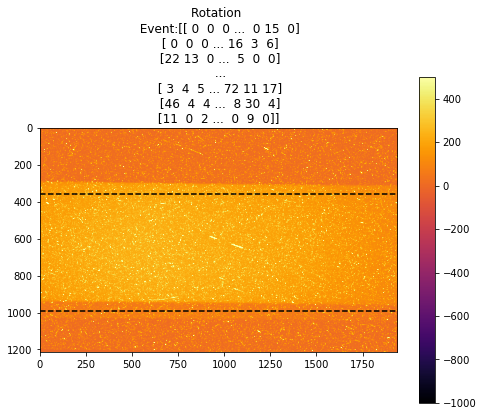

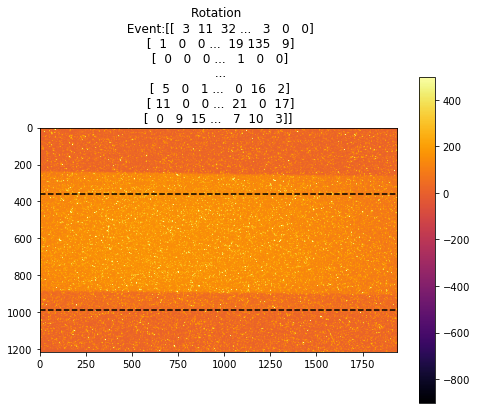

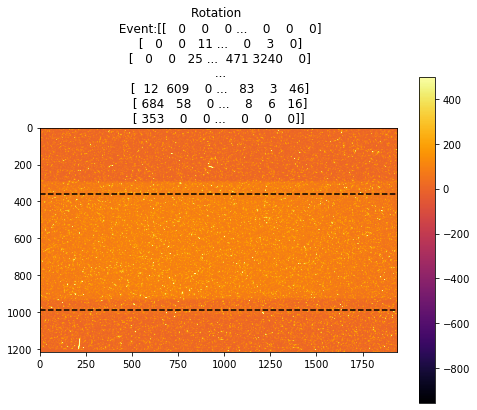

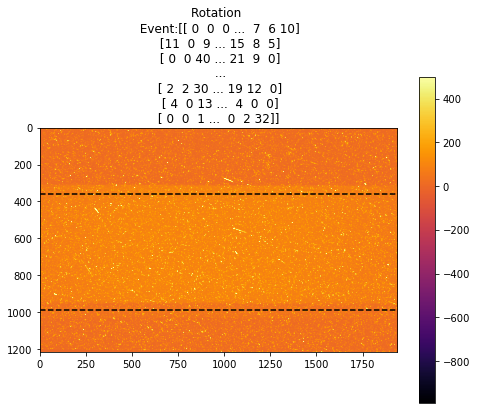

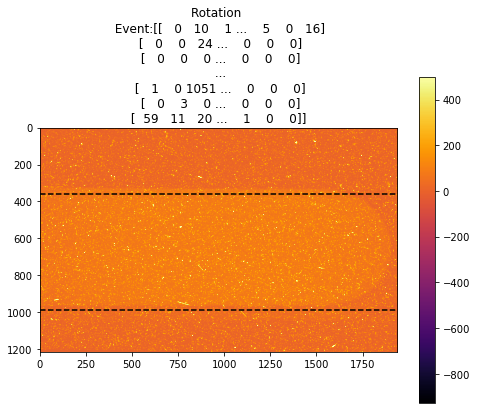

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [45]:
getNewSpecImage_rotated(list_images,rot=-0.9,vmax=500)